In [2]:
!pip install bioread

import bioread

# loading BIOPAC ACQ file
data = bioread.read_file("GRPOUP-11-L10-L10")

# searching channels that exist
for ch in data.channels:
    print(ch.name, ch.samples_per_second, len(ch.data))

# extracting first channel/ eog sig
eog_signal = data.channels[0].data
fs = data.channels[0].samples_per_second


Horizontal 100.0 11632
Vertical 100.0 11632


In [3]:
# creating bandpass filter (to keep important info 0.1-30Hz removes rest of freq)

from scipy.signal import butter, filtfilt

def bandpass_filter(signal, fs, low=0.1, high=30, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    return filtfilt(b, a, signal)

eog_bandpassed = bandpass_filter(eog_signal, fs)


In [4]:
import numpy as np
import scipy
from scipy.signal import butter, filtfilt, iirnotch

print("NumPy version:", np.__version__)
print("SciPy version:", scipy.__version__)


NumPy version: 2.3.2
SciPy version: 1.16.1


In [4]:
# creating notch filter (to remove powerline interference noise), ^Q = narrow stopband. lower Q = wider notch

from scipy.signal import iirnotch

def notch_filter(signal, fs, freq=50.0, Q=30):
    b, a = iirnotch(freq/(fs/2), Q)
    return filtfilt(b, a, signal)

eog_denoised = notch_filter(eog_bandpassed, fs)


In [6]:
!pip install mne


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 33.1 MB/s eta 0:00:00


In [10]:
# removing motion related noise
import mne
import numpy as np

for i, ch in enumerate(data.channels):
    print(i, ch.name)
# channels = horizontal eye movement and vertical
ch_names = [ch.name for ch in data.channels[:2]]
ch_types = ['eeg', 'eog']   # must match length of ch_names

signals = np.array([ch.data for ch in data.channels[:2]])
info = mne.create_info(ch_names=ch_names, sfreq=fs, ch_types=ch_types)
raw = mne.io.RawArray(signals, info)


0 Horizontal
1 Vertical
Creating RawArray with float64 data, n_channels=2, n_times=11632
    Range : 0 ... 11631 =      0.000 ...   116.310 secs
Ready.


In [14]:
import numpy as np
import mne


# applying filtering
signals_filtered = np.array([notch_filter(bandpass_filter(ch, fs), fs) for ch in signals])

# ica
ica = mne.preprocessing.ICA(n_components=2, random_state=42)

# Specify picks explicitly to avoid "no channels" error
ica.fit(raw, picks=[0, 1])

# applying ICA
raw_clean = ica.apply(raw.copy())
eog_clean = raw_clean.get_data()


Fitting ICA to data using 2 channels (please be patient, this may take a while)
Selecting by number: 2 components
Fitting ICA took 0.0s.
Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components


/tmp/ipython-input-1032037170.py:12: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, picks=[0, 1])


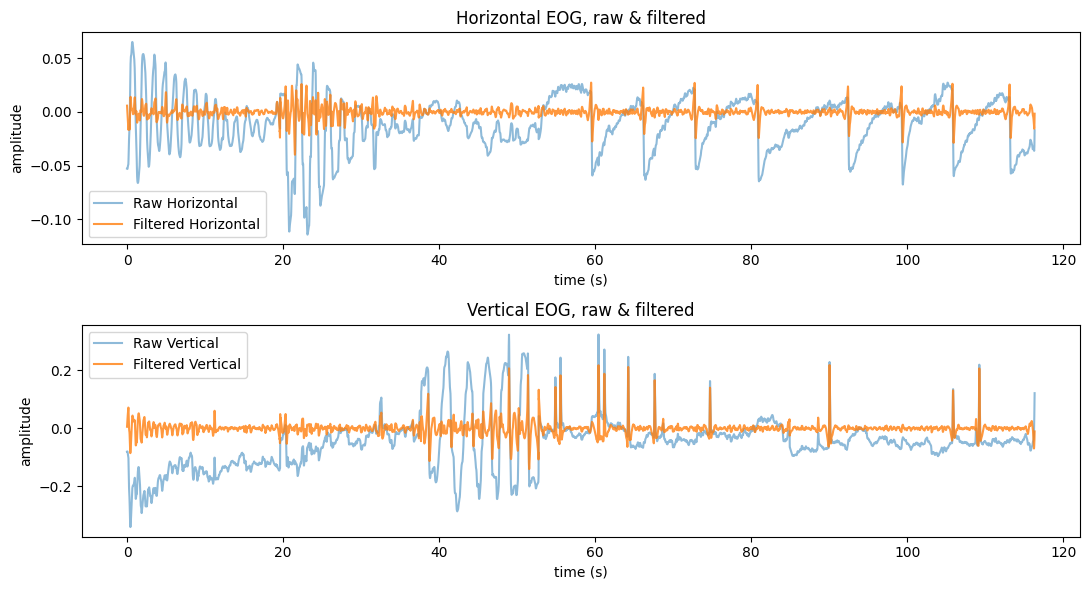

In [21]:
import matplotlib.pyplot as plt

n_times = signals.shape[1]
time = np.arange(n_times) / fs  # in seconds


plt.figure(figsize=(11,6))

# Horizontal channel
plt.subplot(2,1,1)
plt.plot(time, signals[0], label='Raw Horizontal', alpha=0.5)
plt.plot(time, signals_filtered[0], label='Filtered Horizontal', alpha=0.8)
plt.title('Horizontal EOG, raw & filtered')
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.legend()

# Vertical channel
plt.subplot(2,1,2)
plt.plot(time, signals[1], label='Raw Vertical', alpha=0.5)
plt.plot(time, signals_filtered[1], label='Filtered Vertical', alpha=0.8)
plt.title('Vertical EOG, raw & filtered')
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.legend()

plt.tight_layout()
plt.show()


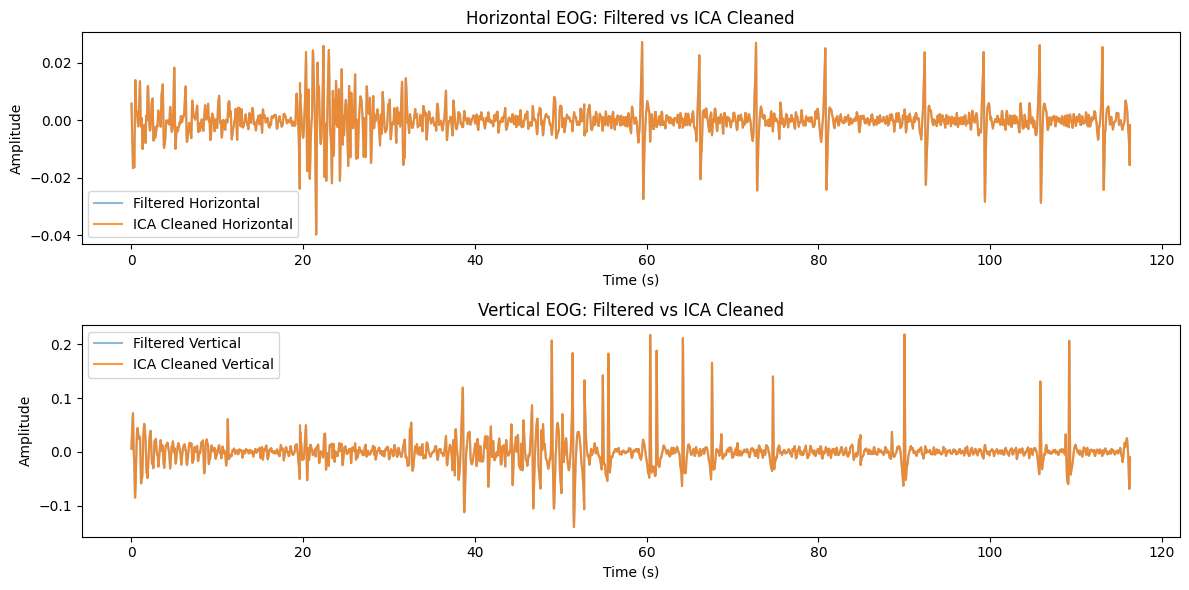

In [22]:
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
plt.plot(time, signals_filtered[0], label='Filtered Horizontal', alpha=0.5)
plt.plot(time, eog_clean[0], label='ICA Cleaned Horizontal', alpha=0.8)
plt.title('Horizontal EOG: Filtered vs ICA Cleaned')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2,1,2)
plt.plot(time, signals_filtered[1], label='Filtered Vertical', alpha=0.5)
plt.plot(time, eog_clean[1], label='ICA Cleaned Vertical', alpha=0.8)
plt.title('Vertical EOG: Filtered vs ICA Cleaned')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()
